In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
def euler(func, t, dt, y):
    ''' Function to perfrom Euler's method for solving ODEs '''
    return dt * func(t, y)

def rk4(func, t, dt, y):
    ''' Function to perfrom Runge-Kutta 4th order method for solving ODEs '''
    k1 = dt * func(t, y)
    k2 = dt * func(t + dt/2, y + k1/2)
    k3 = dt * func(t + dt/2, y + k2/2)
    k4 = dt * func(t + dt, y + k3)
    return (k1 + 2*k2 + 2*k3 + k4) / 6


#### Neural ODEs

In [4]:
# Neural ODE model
class NeuralODE(nn.Module):
    ''' Class to define the Neural ODE model '''
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, y0, t, solver):
        ''' Function to solve the ODE using the solver 
        Args:
            y0: Initial condition
            t: Time points
            solver: Method to solve the ODE (Euler or RK4)
        '''
        solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
        solution[0] = y0
        
        j = 1
        for t0, t1 in zip(t[:-1], t[1:]):
            dy = solver(self.func, t0, t1 - t0,  y0)
            y1 = y0 + dy
            solution[j] = y1
            y0 = y1
            j += 1            
            
        return solution       

Chemical Reaction Example

#### cosine experiment

In [4]:
# Experiments
## Checkout NODE result by giving dynamic of cos(t). The result should be sin(t)
y0 = torch.tensor([0.]).to(device)
t = torch.linspace(0, 6 * np.pi, 1500).to(device)

class cos(nn.Module):
    def forward(self, t, y):
        return torch.cos(t)

# Test the NODE
ode_test = NeuralODE(func = cos()).to(device)
test_result = ode_test(y0 = y0, t=t, solver = euler)
test_result = test_result.transpose(0,1)

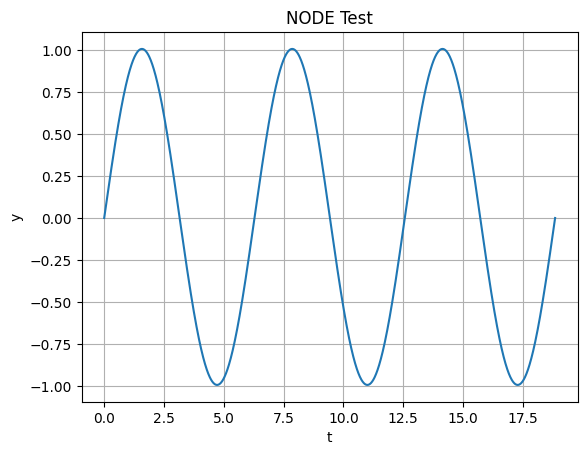

In [5]:
# Visualize the result
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('NODE Test')
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.plot(t.cpu().numpy(), test_result[0].detach().cpu().numpy(), label='NODE')
plt.grid(True)
plt.show()

#### Spiral Experiment

In [6]:
data_size = 2000

In [7]:
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[-.1, 2.], [-2., -.1]]).to(device)

class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)
    
with torch.no_grad():
    node = NeuralODE(func=Lambda()).to(device)
    true_y = node(y0=true_y0, t=t, solver=euler)

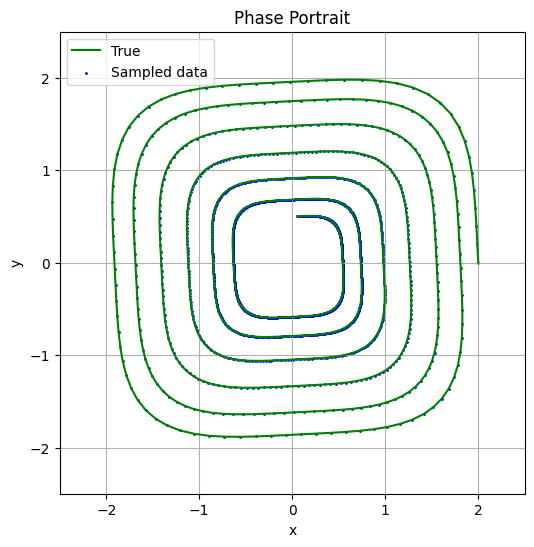

In [52]:
def visualize(true_y, pred_y=None):
    fig = plt.figure(figsize=(6, 6), facecolor='white')
    ax = fig.add_subplot(111)
    ax.set_title('Phase Portrait')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'green', label='True')
    ax.scatter(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], color='blue', label='Sampled data', s=1)
    if pred_y is not None:
        ax.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'red', label='Predicted')
    ax.set_xlim([-2.5, 2.5])
    ax.set_ylim([-2.5, 2.5])
    plt.legend()
    plt.grid(True)
    plt.show()
    
visualize(true_y)

In [53]:
batch_time = 10
batch_size = 16

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (batch_size, 1, emb)
    batch_t = t[:batch_time]  # T
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, batch_size, 1, emb)
    return batch_y0, batch_t, batch_y

In [57]:
# define dynamic function
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        
    def forward(self, t, y):
        return self.net(y**3)

In [58]:
# Train
niters = 400

node = NeuralODE(func=ODEFunc()).to(device)
optimizer = torch.optim.RMSprop(node.parameters(), lr=1e-3)

for iter in tqdm(range(niters + 1)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = node(batch_y0, batch_t, solver=rk4)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()
    
    if iter % 50 == 0:
        pred_y = node(true_y0, t, solver=rk4)
        loss = torch.mean(torch.abs(pred_y - true_y))
        print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
        visualize(true_y, pred_y)
        


  0%|          | 0/401 [00:00<?, ?it/s]


RuntimeError: ArrayRef: invalid index Index = 18446744073709551615; Length = 0